# Домашнее задание № 7

## по дисциплине: Машинное обучение в бизнесе

### выполнил: Евгений Кириллов

### Домашнее задание

Практическое задание:
- взять любой набор данных для бинарной классификации (можно скачать один из модельных с https://archive.ics.uci.edu/ml/datasets.php)
- сделать обзорный анализ выбранного датасета
- сделать feature engineering
- обучить любой классификатор (какой вам нравится)
- разобраться с SHAP и построить важности признаков для:
    - всего тестового набора данных (summary_plot - дать интерпретацию)
    - для топ 10%
- для отдельных наблюдений вывести force_plot и попытаться проинтерпретировать результат

data set taken: https://archive.ics.uci.edu/ml/datasets/Adult

In [1]:
import pandas as pd
import numpy as np

from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_curve, confusion_matrix, classification_report, f1_score
from sklearn.preprocessing import StandardScaler

# from sklearn.linear_model import LogisticRegression
# from sklearn.ensemble import GradientBoostingClassifier
from lightgbm import LGBMClassifier

import itertools
import math

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
df = pd.read_csv("adult_data.csv", 
                 names=['age', 'workclass', 'census-bureau-weight', 'education', 'education-num',
                        'marital-status', 'occupation', 'relationship', 'race', 'sex', 
                        'capital-gain', 'capital-loss', 'hours-per-week', 'native-country', 'target']) 

In [3]:
df.head(2)

,age,workclass,census-bureau-weight,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,target
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K


In [4]:
df.isna().sum().sum()

0

In [5]:
df.shape

(32561, 15)

In [6]:
df.dtypes

age                      int64
workclass               object
census-bureau-weight     int64
education               object
education-num            int64
marital-status          object
occupation              object
relationship            object
race                    object
sex                     object
capital-gain             int64
capital-loss             int64
hours-per-week           int64
native-country          object
target                  object
dtype: object

In [7]:
df_num_features = df.select_dtypes(include=['int64'])

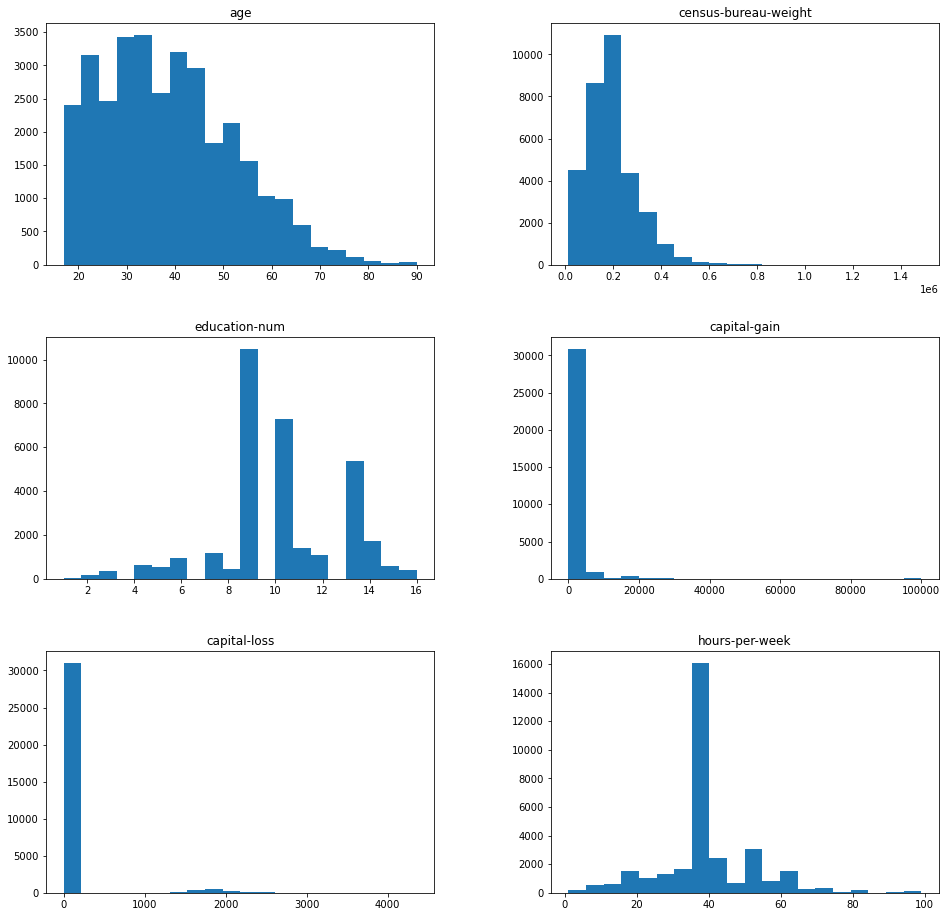

In [8]:
df_num_features.hist(figsize=(16, 16), bins=20, grid=False);

### target preprocessing

In [9]:
df['target'] = df['target'].map({
    ' <=50K': 0,
    ' >50K': 1
})

In [10]:
df['target'].value_counts()

0    24720
1     7841
Name: target, dtype: int64

### train_test_split

In [11]:
X_train, X_test, y_train, y_test = train_test_split(df.drop(['target'], axis=1), 
                                                    df['target'], 
                                                    test_size=0.3,
                                                    random_state=2022)

### preprocessing and feature generating

In [12]:
class DataPreprocessingAndFeatureGenerating:
    def __init__(self):
        self.list_of_numerical_features = None
        self.list_of_features_to_drop = [
#             'census-bureau-weight',
#             'education',
            'native-country'
        ]
        self.scaler = StandardScaler()
    
    def fit(self, X):
        # generating statistics for features to scale
        self.list_of_numerical_features = X.select_dtypes(include=['int64']).columns
        self.scaler.fit(X[self.list_of_numerical_features])

    def transform(self, X):
        # scaling numerical features
        X[self.list_of_numerical_features] = self.scaler.transform(X[self.list_of_numerical_features])
        
        # generating dummies
        X['sex'] = df['sex'].map({' Male': 1, ' Female': 0})  # dummies for 'sex'
        X = X.drop(self.list_of_features_to_drop, axis=1)  # dropping categorical features not needed
        
        X = pd.get_dummies(X)
        
        # fixing names of columns
        X.columns = [_.replace(' ', '').lower() for _ in X.columns]
        
        return X

In [13]:
data_preprocessor_and_feature_generator = DataPreprocessingAndFeatureGenerating()

data_preprocessor_and_feature_generator.fit(X_train)

X_train = data_preprocessor_and_feature_generator.transform(X_train)
X_test = data_preprocessor_and_feature_generator.transform(X_test)

### model

In [14]:
model = LGBMClassifier(random_state=2022)

In [15]:
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

### metrics

In [16]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.90      0.94      0.92      7436
           1       0.77      0.65      0.71      2333

    accuracy                           0.87      9769
   macro avg       0.83      0.79      0.81      9769
weighted avg       0.87      0.87      0.87      9769



# shap

- разобраться с SHAP и построить важности признаков для:
    - всего тестового набора данных (summary_plot - дать интерпретацию)
    - для топ 10%
- для отдельных наблюдений вывести force_plot и попытаться проинтерпретировать результат

In [17]:
import shap
shap.initjs()

In [18]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


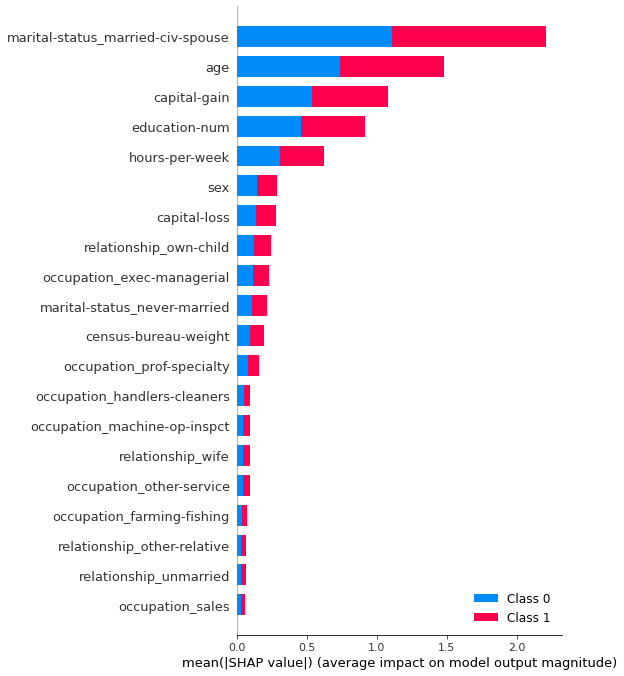

In [19]:
shap.summary_plot(shap_values, X_test)

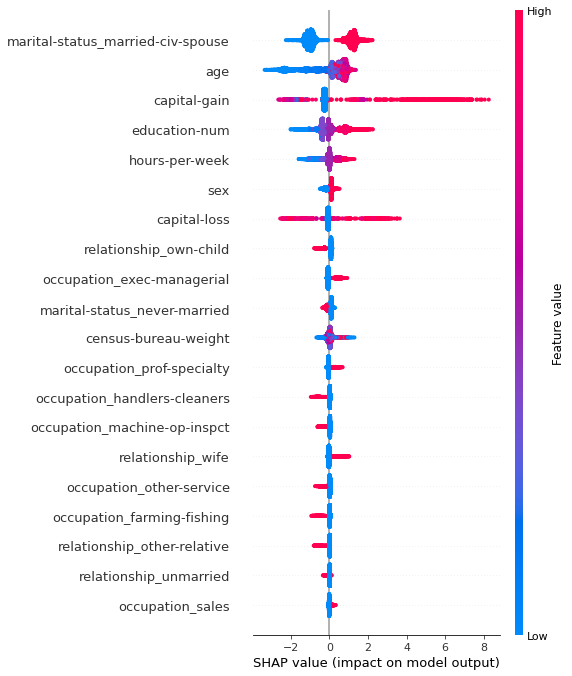

In [20]:
target_class = 1
shap.summary_plot(shap_values[target_class], X_test)

In [21]:
idx = 2
target_class = 1
shap.force_plot(explainer.expected_value[target_class], shap_values[target_class][idx,:], X_test.iloc[idx,:])

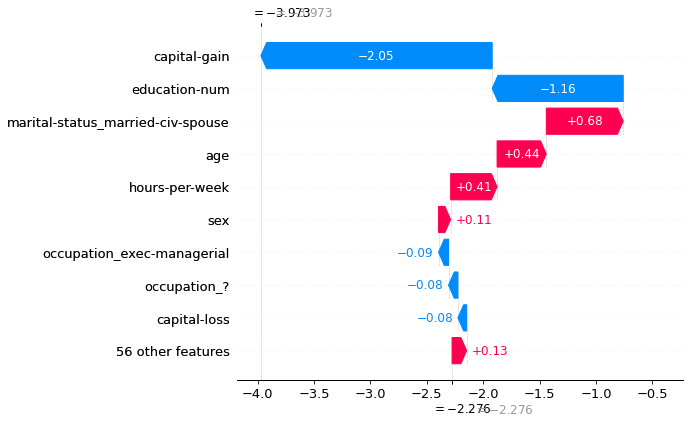

In [22]:
idx = 33
target_class = 1
shap.plots._waterfall.waterfall_legacy(explainer.expected_value[target_class],
                                       shap_values[target_class][idx], 
                                       feature_names=X_test.columns,
                                       max_display=10)